# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

#My imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (HalvingGridSearchCV, cross_val_score, RepeatedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix)
import seaborn as sns
from scipy.stats import ttest_ind




In [404]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [405]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [406]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


/tmp/ipykernel_64074/3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
/tmp/ipykernel_64074/3482823818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [407]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [408]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

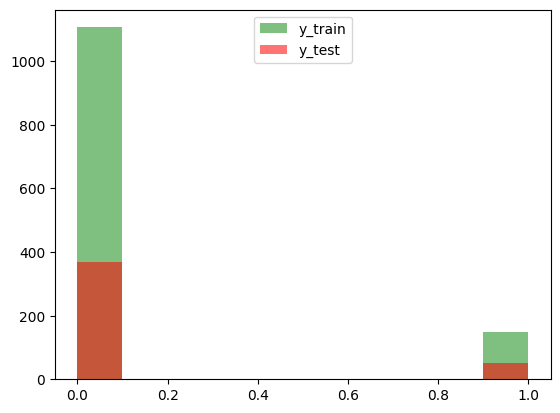

In [409]:
#TODO: visualiser y_train og y_test i et histogram
bins = np.linspace(y_train.min(), y_train.max(), 3)
plt.hist(y_train, alpha=0.5, label="y_train", color="green")
plt.hist(y_test, alpha=0.55, label="y_test", color="red")
plt.legend(loc="upper center")
plt.show()

**Svar:**

Kan veldig tydlig se en binær fordelig og kan derfor si med stor sannsynlighet at det er et klassifiseringsproblem vi skal løse. I klassifiseringsproblemer er det diskrete verdier som dataene faller under, i motsettning til regressjon der det er flytende verdier. I et klassifiseringsproblem skal man fordele dataene i to eller flere kategorier utifra hva man ønsker, her er det to kategorier vi deler det inn i, "Skal oppsiges" og "Skal ikke oppsiges"

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


In [410]:
#TODO: repeterte kryssvalideringer for to modeller
RAND_STATE: int = 12 #Define randstate to be used for all models

def hyper_search(X: pd.DataFrame, y: pd.Series, model: RandomForestClassifier|LogisticRegression, param_grid: dict):
	'''
	Hyper Parmameter Search using the RandomForestClassifier model and HalvingGridSearchCV from sklearn.
	'''
	search = HalvingGridSearchCV( #HalvingGridSearchCV is significanly faster than GridSearchCV while giving just as accurate results, but it is experimental...
		estimator= model, #use RandomForestClassifier model
		param_grid=param_grid, #Pass the param grid
		scoring='accuracy', #Scoring parameter, "neg_mean_squared_error" as per the assignment 
		cv=5, #Determines the cross-validation splitting strategy, 5-fold is used here as per the assignment
		n_jobs=-1 #How many jobs to run in parallel, defaults to none. -1 means all available processors. Significantly affects speed
		).fit(X, y) #Fit the search afterwards

	return search.best_params_, search.best_score_

#Define Search parameters used for both RandomForestClassification and LogisticRegression
rfc_param_grid= { 
	'max_depth': [None, 3, 4, 5, 10, 20],
	'min_samples_split': [2, 5, 10],
	'n_estimators': [10, 25, 50, 75, 100, 150]
}

lr_param_grid = {
	'C':[1, 2, 3, 5, 10],
	'solver':["saga", "liblinear"],
	'max_iter': [10_000, 20_000, 50_000]
}

rfc = RandomForestClassifier(random_state=RAND_STATE)
lr = LogisticRegression(random_state=RAND_STATE)

rfc_params, rfc_score = hyper_search(X_train, y_train, rfc, rfc_param_grid)
lr_params, lr_score = hyper_search(X_train, y_train, lr, lr_param_grid)


/home/mikael/Documents/Programming/BTS4210-1-24H---Oblig1/DMBA2024-Mikael/Oblig 2/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/mikael/Documents/Programming/BTS4210-1-24H---Oblig1/DMBA2024-Mikael/Oblig 2/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [411]:

print(f"RandomForestClassifier -> Params: {rfc_params} \n\tScore: {rfc_score:.2f}")
print(f"LogisticalRegression -> Params: {lr_params} \n\tScore: {lr_score:.2f}")


RandomForestClassifier -> Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50} 
	Score: 0.89
LogisticalRegression -> Params: {'C': 10, 'max_iter': 20000, 'solver': 'saga'} 
	Score: 0.88


In [412]:
#TODO: Skår ytelsen til modellene ved hjelp av F1-score og accuracy
def crossvalidation(X: pd.DataFrame, y: pd.Series, model_str: str, params: dict, K: int = 5) -> list:
	'''
	Performs crossvalidation on X and y with the specified parameters, these should be the best parameters found
	 using a hyperparameter search funtion.
	'''
	#Define both the model used and KFold, here K>=5 as per the assignment
	rkf = RepeatedKFold(n_splits=K, random_state=RAND_STATE)

	#Create the scoreres
	f1_scorer = make_scorer(f1_score, average="weighted")
	accuracy_scorer = make_scorer(accuracy_score)

	#Match statement for the models used
	match model_str:
		case "rfc":
			model = RandomForestClassifier(random_state=RAND_STATE, **params)
		case "lr":
			model = LogisticRegression(random_state=RAND_STATE, **params)

	#Perform crossevauation using f1-score and accurasy for scoring
	score_f1 : np.ndarray = cross_val_score(model, X, y, cv = rkf, scoring=f1_scorer, n_jobs=-1, verbose=0)
	score_accuracy : np.ndarray = cross_val_score(model, X, y, cv = rkf, scoring=accuracy_scorer, n_jobs=-1, verbose=0)

	return score_f1, score_accuracy

rfc_scores_f1, rfc_scores_accuracy = crossvalidation(X_train, y_train, "rfc", rfc_params)
lr_scores_f1, lr_scores_accuracy = crossvalidation(X_train, y_train, "lr", lr_params)


In [413]:
print(f"RFC ->   F1: {np.mean(rfc_scores_f1):.4f} | Acc: {np.mean(rfc_scores_accuracy):.4f}")
print(f"LR  ->   F1: {np.mean(lr_scores_f1):.4f} | Acc: {np.mean(lr_scores_accuracy):.4f}")

RFC ->   F1: 0.8462 | Acc: 0.8871
LR  ->   F1: 0.8249 | Acc: 0.8807


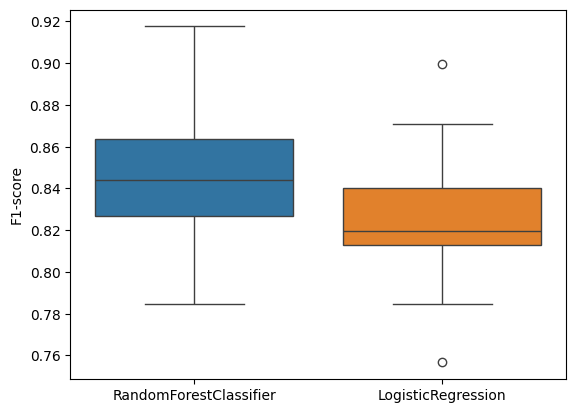

T-Stat: 3.93693 | P-Value: 0.00015
Significant difference: True


In [414]:
#TODO: Visualiser F1-score fra de repitertekryssvalideringende som et boksplott

def boxplot_scores(scores_dict: dict[list[float]]):
	#Seperate the input dict into two lists, one for the data and one for naming the boxes
	scores_list : list[float] = list(scores_dict.values())
	names_list: list[str] = list(scores_dict.keys())
	
	sns.boxplot(scores_list) #Create a boxplot for the data
	plt.ylabel("F1-score") #Label the y-axis
	plt.xticks([i for i in range(len(names_list))],names_list) #Set the names of each boxplot to their respective one
	plt.show()

scores_dict: dict[str:list[float]] = {
	"RandomForestClassifier":rfc_scores_f1,
	"LogisticRegression":lr_scores_f1,
}

boxplot_scores(scores_dict) #Display boxplot of scores

t_stat, p_value = ttest_ind(rfc_scores_f1, lr_scores_f1, alternative="two-sided") #Perform a t-test on the f1-scores of RFC and LR

print(f"T-Stat: {t_stat:.5f} | P-Value: {p_value:.5f}")
print(f"Significant difference: {p_value < 0.05}") 


**Svar:**

På boksplottet ser det ut som om RandomForestClassifier har høyere F1-Score enn LogisicRegression. En t-test på resultatene viser en p-verdi på 0.00015 som er lavere enn en p-verdi 0.05 (som er en vanlig p-verdi å bruke for å si om et resultat er signifikant eller ikke).

En kan derfor si at det er en stor sannsynlighet at forskjellen mellom de to modellene er signifikant og at RandomForestClassifier er bedre enn LogisticRegression

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

In [415]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def crossvalidation_smote(X, y, model) -> tuple:
	#Define ReapetedKFold
	rkf = RepeatedKFold(n_splits=5, random_state=RAND_STATE)

	#Create the scoreres used
	f1_scorer = make_scorer(f1_score, average="weighted")
	accuracy_scorer = make_scorer(accuracy_score)

	#Define Smote and pipeline used. Applying first smote then the inputted model (RFC or LR)
	smote = SMOTE(random_state=RAND_STATE, sampling_strategy="minority")
	pipeline = Pipeline([('smote', smote), ('model', model)])
	
	#Perform crossvalidation using both f1 and accuracy
	f1_scores = cross_val_score(pipeline, X, y, cv=rkf, scoring=f1_scorer)
	accuracy_scores = cross_val_score(pipeline, X, y, cv=rkf, scoring=accuracy_scorer)
	
	return f1_scores, accuracy_scores

rfc_smote_scores_f1, rfc_smote_scores_accuracy = crossvalidation_smote(X, y, rfc)
lr_smote_scores_f1, lr_smote_scores_accuracy = crossvalidation_smote(X, y, lr)


/home/mikael/Documents/Programming/BTS4210-1-24H---Oblig1/DMBA2024-Mikael/Oblig 2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mikael/Documents/Programming/BTS4210-1-24H---Oblig1/DMBA2024-Mikael/Oblig 2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also re

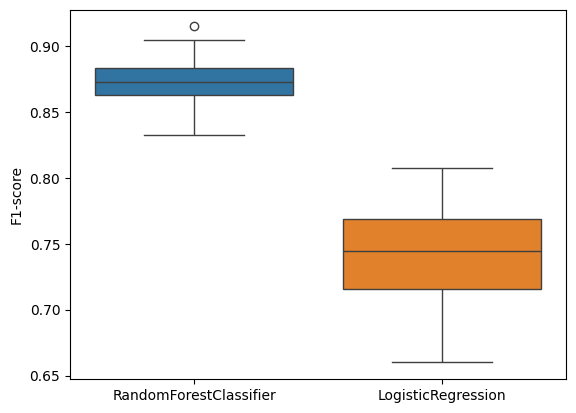

SMOTE -> T-stat: 23.64064 | P-Value: 0.00000
Significant Difference: True


In [420]:
smote_scores_dict: dict[str:list[float]] = {
	"RandomForestClassifier": rfc_smote_scores_f1,
	"LogisticRegression": lr_smote_scores_f1,
}

boxplot_scores(smote_scores_dict)

t_stat_smote, p_value_smote = ttest_ind(rfc_smote_scores_f1, lr_smote_scores_f1, alternative="two-sided")
print(f"SMOTE -> T-stat: {t_stat_smote:.5f} | P-Value: {p_value_smote:.5f}")
print(f"Significant Difference: {p_value_smote < 0.05}")

**Svar:**

Boksplottet viser igjen at RandomForestClassifier har høyere F1-score enn LogisticRegression. T-testen her gir en P-Verdi på ~0.00 som vil si at det er en eksremt stor sannsynlighet for at forskjellen i F1-score er signifikant. Dette samsvarer med resultatene fra oppgave 2.2 der den også viste til at RFC var en bedre modell enn LR i dette tilfellet. Bruken av smote at økt T-stat mye samtidig som p-verdien har blitt mindre.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [438]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

def measure_performance(y_test, y_pred):
	#Calculate specificity using a confusion matrix
	true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred).ravel()
	specificity = true_negative / (true_negative+false_positive)

	#Dict for multiple functions that require the exact same inputs
	dupe_inputs: dict = {
		"y_true":y_test,
		"y_pred":y_pred,
		"average":"weighted"
	}

	#Basic score functions provided by sklearn.metrics
	accuracy = accuracy_score(y_test, y_pred)
	precision = precision_score(**dupe_inputs)
	score_f1 = f1_score(**dupe_inputs)
	sensitivity = recall_score(**dupe_inputs) #Recall = sensitivity

	return sensitivity, specificity, precision, score_f1, accuracy


In [440]:
#Create Initial Model
start_rfc = RandomForestClassifier(random_state=RAND_STATE)
start_params = { 
	'max_depth': [None, 3, 4, 5, 10, 20],
	'min_samples_split': [2, 5, 10],
	'n_estimators': [10, 25, 50, 75, 100, 150]
}

#Find best Parameters using hyperparameter search
best_rfc_param_grid, best_rfc_score, = hyper_search(X_train, y_train, start_rfc, start_params)

#Create best model using params found above and fit it
best_rfc = RandomForestClassifier(random_state=RAND_STATE, **best_rfc_param_grid).fit(X_train, y_train)

#Create Prediciton
y_pred = best_rfc.predict(X_test)

#Measure the things shown below
sensitivity, specificity, precision, score_f1, accuracy = measure_performance(y_test, y_pred)

In [474]:

def print_stats(sensitivity, specificity, precision, score_f1, accuracy, name: str|None = None):
	if name:
		print(f"Stats for {name}")
	print(f"Sensitivity: \t{sensitivity:.4f}")
	print(f"Specificity: \t{specificity:.4f}")
	print(f"Precision: \t{precision:.4f}")
	print(f"F1-Score: \t{score_f1:.4f}")
	print(f"Accuracy Score:\t{accuracy:.4f}")
	print()
print_stats(sensitivity, specificity, precision, score_f1, accuracy)

Sensitivity: 	0.8810
Specificity: 	0.9946
Precision: 	0.8388
F1-Score: 	0.8337
Accuracy Score:	0.8810



#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [480]:
#TODO: Gjør kjønnsbasert analyse på testdataene
#Split df into male_df and female_df based on gender
male_df, female_df = [x for _, x in df.groupby(df['Gender'] == 1)]


#Split X_test dataframe into genders 
X_test_male, X_test_female = [x for _, x in X_test.groupby(X_test['Gender'] == 1)]
y_test_male, y_test_female = [x for _, x in y_test.groupby(X_test['Gender'] == 1)]

print(f"Num Males: {len(X_test_male)}\nNum Females: {len(X_test_female)}")
print(f"M2F Ratio: {len(X_test_male)/len(X_test_female):.2f}\n")


#Create Prediciton
y_pred_male = best_rfc.predict(X_test_male)
y_pred_female = best_rfc.predict(X_test_female)

#Measure the things shown below
male_sensitivity, male_specificity, male_precision, male_score_f1, male_accuracy = measure_performance(y_test_male, y_pred_male)
female_sensitivity, female_specificity, female_precision, female_score_f1, female_accuracy = measure_performance(y_test_female, y_pred_female)
print_stats(male_sensitivity, male_specificity, male_precision, male_score_f1, male_accuracy, "Males")
print_stats(female_sensitivity, female_specificity, female_precision, female_score_f1, female_accuracy, "Females")



Num Males: 253
Num Females: 167
M2F Ratio: 1.51

Stats for Males
Sensitivity: 	0.8617
Specificity: 	0.9954
Precision: 	0.8359
F1-Score: 	0.8080
Accuracy Score:	0.8617

Stats for Females
Sensitivity: 	0.9102
Specificity: 	0.9935
Precision: 	0.8389
F1-Score: 	0.8731
Accuracy Score:	0.9102



|             | Menn   | Kvinner |
|-------------|--------|--------|
| Sensitivity | 0.8617 | 0.9102 |
| Specificity | 0.9954 | 0.9935 |
| Precision   | 0.8359 | 0.8389 |
| F1-Score    | 0.8080 | 0.8731 |
| Accuracy    | 0.8617 | 0.9102 |

* Sensitivitet -> Vi ser har menn har en del lavere (0.05) sensitivitet enn kvinner, som kan bety at modellen er dårligere på å gjennkjenne ekte positiver hos menn enn kvinner
* Spesifisitet -> Menn og kvinner har så å si den samme spesifisiteten, så modellen er like god på å gjennkjenne ekte negativer hos begge kjønn
* Presisjon -> Presisjonen er nesten helt lik for menn og kvinner

Modellen er nesten like god for menn og kvinner men er litt flinkere på å gjennkjenne ekte ektre positiver hos kvinner. Så like god? Nei. Men nesten like god.

Noen mulige årsaker for den lille ubalansen kan være:
* Det er ganske mange fler menn enn kvinner i datasettet, med ca 1.51 menn per kvinne. Noe som burde gjøre modellen bedre på å predikere utfall for menn, men her er det faktisk motsatt...
* Det kan ligge biaser i dataen, f.eks kan det hende at kvinner gjenerelt tjener mindre enn menn i samme/like roller som kan påvirke dataene
* Bedre "Tuning" av modeller i for eksempell hyperparameter search kan føre til bedre resultater, men også koste betraklig mer ressurser (eg. tid)


Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [ ]:
#!pip freeze > requirements.txt